In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
import os
import glob
import random


import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.distributions.empirical_distribution import ECDF

from pmdarima.arima import auto_arima

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from numpy import array
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Concatenate
from keras.layers import RepeatVector

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

from keras.layers import TimeDistributed, RepeatVector
from tensorflow.keras import layers

import tensorflow as tf
from datetime import datetime
from textwrap import wrap
import itertools

from sklearn.model_selection import train_test_split

In [2]:
os.chdir(os.path.dirname(os.path.abspath("__file__")))

In [3]:
timeseries_dfs = []
summary_dfs = []

# Read all csv files from directory
# Sort files into timeseries and summary data
for file_path in glob.glob('D:/Flood Deep Learning/**/*.csv', recursive=True):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    df = pd.read_csv(file_path, low_memory=False) 

    #skip these files
    if file_name in ['streamflow_QualityCodes']:
        continue

    if 'year' in df.columns:    
        df['source'] = file_name
        df= df[df['year'] > 1990]
        df= df.drop_duplicates(['year','month','day'])
        timeseries_dfs.append(df)
    else:
        df = df.rename({'ID':'station_id'}, axis=1)
        df = df.set_index('station_id')
        summary_dfs.append(df)

timeseries_data = pd.concat(timeseries_dfs, axis=0, ignore_index=True)
timeseries_data['date'] = pd.to_datetime(timeseries_data[['year', 'month', 'day']])
timeseries_data = timeseries_data.drop(['year', 'month', 'day'], axis=1)

summary_data = pd.concat(summary_dfs, axis=1)

In [4]:
class PrepareData():
    def __init__(self, timeseries_data=timeseries_data, summary_data=summary_data):
        ### Data Cleaning
        self.timeseries_data = timeseries_data.replace(-99.99,np.NaN)
        
        ### Feature Engineering
        # get precipitation deficit
        actualTransEvap_data = self.timeseries_data[self.timeseries_data['source'] == 'et_morton_actual_SILO'].drop(['source'], axis=1)
        precipitation_data = self.timeseries_data[self.timeseries_data['source'] == 'precipitation_AWAP'].drop(['source'], axis=1)
         
        actualTransEvap_data = actualTransEvap_data[actualTransEvap_data['date'].isin(precipitation_data['date'])].reset_index(drop=True)
        precipitation_data = precipitation_data[precipitation_data['date'].isin(actualTransEvap_data['date'])].reset_index(drop=True)
        
        self.precipitation_deficit = precipitation_data.drop(['date'], axis=1).subtract(actualTransEvap_data.drop(['date'], axis=1))
        self.precipitation_deficit['source'] = 'precipitation_deficit'
        self.precipitation_deficit['date'] = precipitation_data['date']
        
        # get flood probabilities
        self.streamflow_data = self.timeseries_data[timeseries_data['source'] == 'streamflow_MLd_inclInfilled'].drop(['source'], axis=1)
        self.streamflow_data = self.streamflow_data.set_index('date')
        
        self.flood_probabilities = self.streamflow_data.apply(self.flood_extent, axis=0)
        self.flood_probabilities['source'] = 'flood_probabilities'
        self.flood_probabilities['date'] = self.streamflow_data.index
        
        self.flood_indicator = self.flood_probabilities.applymap(lambda x: int(x <0.05) if pd.isnull(x) == False and isinstance(x, float) else x)
        self.flood_indicator['source'] = 'flood_indicator'
        self.flood_indicator['date'] = self.flood_probabilities['date']        
        
        # turn date into sin and cos function 
        date_min = np.min(self.flood_probabilities['date'])
        year_seconds = 365.2425*24*60*60
        year_sin = self.flood_probabilities['date'].apply(lambda x: np.sin((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        year_cos = self.flood_probabilities['date'].apply(lambda x: np.cos((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        all_stations = list(self.flood_probabilities.drop(columns=['source', 'date'], axis=1).columns) 
        
        df_sin = []     
        for value in year_sin:
            df_sin.append({k:value for k in all_stations})
            
        df_sin = pd.DataFrame(df_sin)
        df_sin['source'] = 'year_sin'
        df_sin['date'] = self.flood_probabilities['date']
 
        df_cos = []
        for value in year_cos:
            df_cos.append({k:value for k in all_stations})
            
        df_cos = pd.DataFrame(df_cos)
        df_cos['source'] = 'year_cos'
        df_cos['date'] = self.flood_probabilities['date']
            
        ### Return
        self.timeseries_data = pd.concat([self.timeseries_data, self.precipitation_deficit, self.flood_probabilities, df_sin, df_cos, self.flood_indicator], axis=0).reset_index(drop=True)
        self.summary_data = summary_data
        
    def get_timeseries_data(self, source, stations):      
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        return self.data_filtered
        
        
    def get_data(self, source, stations):
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]
     
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(timeseries_source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                self.data_filtered[station, variable] = value
        
        return self.data_filtered.sort_index(axis=1)
    

    
    def get_train_val_test(self, source, stations, 
                           scaled=True, target=['streamflow_MLd_inclInfilled'],
                           start=None, end=None,
                           discard=0.05, train=0.6, test=0.4):
        assert 0<=discard<=1
        assert (train + test) == 1
     
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]        
        
        all_data = self.get_timeseries_data(timeseries_source, stations).loc[start:end]
        n_rows_all = len(all_data)
        
        all_data_discarded = all_data.iloc[int(n_rows_all*discard):]
        n_rows_discarded = len(all_data_discarded)
        
        train_df = all_data_discarded[:int(n_rows_discarded*train)]
        test_df = all_data_discarded[-int(n_rows_discarded*(test)):]
        
        if scaled == True:
            scaler = MinMaxScaler()
            scaler.fit(train_df)
            
            scaler_test = MinMaxScaler()
            scaler_test.fit(test_df)
            
            train_df = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
            test_df = pd.DataFrame(scaler_test.transform(test_df), index=test_df.index, columns=test_df.columns)
            
     
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                
                train_df[station, variable] = value                
                test_df[station, variable] = value 
                                  
        return train_df.sort_index(axis=1), test_df.sort_index(axis=1) 
    
    def flood_extent(self, streamflow_ts):
        station_name = streamflow_ts.name

        flow_data = pd.DataFrame(streamflow_ts)  
        na_values = flow_data[flow_data[station_name].isna()][station_name]

        flow_data = flow_data.dropna().sort_values(by=station_name, ascending=False).reset_index()
        flow_data['probability'] = (flow_data.index + 1)/(1+len(flow_data)) 
        flow_data = flow_data.sort_values(by='date').drop(['date', station_name], axis=1)['probability']
        flow_data = pd.concat([na_values, flow_data]).reset_index(drop=True) 
        flow_data.name = station_name  

        return flow_data 

In [5]:
camels_data = PrepareData()

In [6]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, test_df, 
                 station, filtered=None, label_columns=None):

        # Store the raw data.
        self.train_df = train_df[station]
        self.test_df = test_df[station]
        self.station = station
        self.filtered = filtered
        
        # validation
        if self.filtered == 'upper_soil_filter':
            assert('upper_soil_indicator' in list(self.train_df.columns))
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data, filtered=None, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=shuffle,
                batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        if filtered == 'upper_soil_filter':
            indicator_index = list(self.train_df.columns).index('upper_soil_indicator')
            ds = ds.unbatch().filter(lambda x, y: tf.math.reduce_sum(x[:, indicator_index]) > 0).batch(32)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df, filtered=self.filtered)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)
           
    @property
    def test_windows(self):
        total_size = self.test_array.shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    @property
    def test_array(self):
        return array(self.test_df[self.label_columns])
       
    def test_indicator(self, filtered):
        if filtered == 'upper_soil_filter':
            return array(self.test_df['upper_soil_indicator'])       

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
            
        return result
       
    @property
    def num_features(self):
        return self.train_df.shape[1]
    
    def test_example(self, index):
        return np.array(self.test_df.iloc[index]).reshape(1, 1, self.num_features)

    def plot(self, model=None, plot_col='streamflow_MLd_inclInfilled', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [7]:
class MultiWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df,test_df, stations, 
                 statics='separate', filtered=-1000, label_columns=None):
     
        # Store the raw data.
        self.train_df = train_df       
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations) 

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.filtered = filtered
           
        self.trains = []
        self.tests = []        

        for i, s in enumerate(stations):
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)

            padding = np.zeros((input_width, self.total_stations), dtype=np.float32)
            padding[:, i] = 1

            self.trains.append(window.train.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            self.tests.append(window.test.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            
    @property
    def train(self):
        ds = tf.data.Dataset.from_tensor_slices(self.trains)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: tf.math.reduce_max(y) > self.filtered)
        
        return concat_ds.batch(32)


    @property
    def test(self):
        ds = tf.data.Dataset.from_tensor_slices(self.tests)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
        
        return concat_ds.batch(32)


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])
    
    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [8]:
class MultiNumpyWindow():
    def __init__(self, input_width, label_width, shift,
                 timeseries_source, summary_source, summary_data,
                 stations, label_columns=None):
        
        train_df, test_df = camels_data.get_train_val_test(source=timeseries_source,
                                                                   stations=stations)      
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations)
        
        self.num_timeseries_features = len(timeseries_source)
        self.num_static_features = len(summary_source)     
        self.timeseries_source = timeseries_source
        self.summary_source = summary_source      
    
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.train_timeseries = []
        self.test_timeseries = []  
        
        self.train_static = []
        self.test_static = [] 
        
        self.train_y = []
        self.test_y = []
        
        for i, s in enumerate(stations):
            # process timeseries
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)
            
            x_train, y_train = self.mapdata_tonumpy(window.train)
            x_test, y_test = self.mapdata_tonumpy(window.test)
            
            self.train_timeseries.extend(x_train) 
            self.test_timeseries.extend(x_test) 
            
            self.train_y.extend(y_train) 
            self.test_y.extend(y_test)      
            
            # process static
            static = summary_data[summary_source].loc[s].to_numpy()         
            padding = np.zeros((self.total_stations, ), dtype=np.float32)
            padding[i] = 1
            
            static = np.concatenate([static, padding], axis=0)
            
            self.train_static.extend([static for _ in range(x_train.shape[0])])
            self.test_static.extend([static for _ in range(x_test.shape[0])])
            
        self.train_timeseries = np.array(self.train_timeseries)
        self.test_timeseries = np.array(self.test_timeseries) 
        
        self.train_static = np.array(self.train_static)
        self.test_static = np.array(self.test_static)
        
        scaler = MinMaxScaler()
        scaler.fit(self.train_static)
        
        self.train_static = scaler.transform(self.train_static)
        self.test_static = scaler.transform(self.test_static)
                
        
        #self.train_static = np.ones((self.train_static.shape[0], self.train_static.shape[1]))
        
        self.train_y = np.array(self.train_y) 
        self.train_y = np.swapaxes(self.train_y, 1, 2)

        
        self.test_y = np.array(self.test_y)
        self.test_y = np.swapaxes(self.test_y, 1, 2)        

    def mapdata_tonumpy(self, map_ds):
        map_ds = map_ds.unbatch()

        x_array = []
        y_array = []

        for ts in map_ds:
            x = ts[0]
            y= ts[1]

            x_array.append(x.numpy())
            y_array.append(y.numpy())

        return np.array(x_array), np.array(y_array) 
    
    @property
    def train(self):
        return self.train_timeseries, self.train_static, self.train_y


    @property
    def test(self):      
        return self.test_timeseries, self.test_static, self.test_y


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])

In [11]:
class CustomLoss():  
    def qloss_95(y_true, y_pred, q=0.95):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
        
    def qloss_90(y_true, y_pred, q=0.9):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
    def qloss_70(y_true, y_pred, q=0.7):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
    def qloss_50(y_true, y_pred, q=0.5):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
class Model():
    MAX_EPOCHS = 150
    
    def __init__(self, window):
        # Store the raw data.
        self.window = window
        
        self.train_df = self.window.train_df
        self.test_df = self.window.test_df
             
    def compile_and_fit(self, model, window, loss_func, patience=10):

        model.compile(loss=loss_func,
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=self.MAX_EPOCHS,
                            verbose=0)

        return history

    def num_flood_events(self, cut=1):
        actuals = np.squeeze(self.window.test_windows, axis=2) 
        cut_percentile = np.percentile(actuals.flatten(), cut)
        locs = np.unique(np.where(actuals<cut_percentile)[0])

        events = np.split(locs, np.cumsum( np.where(locs[1:] - locs[:-1] > 1) )+1)

        return len(events)
    
    def summary(self, station=None):
        summary_dict = {}
        
        summary_dict['model_name'] = self.model_name
        summary_dict['input_width'] = self.window.input_width
        summary_dict['label_width'] = self.window.label_width
             
        if station == None:
            summary_dict['station'] = self.window.station
            summary_dict['inputs'] = str(list(self.train_df.columns))
            summary_dict['NSE'] = self.get_NSE()
        else:
            summary_dict['station'] = station
            example_station = self.train_df.columns.get_level_values(0)[0]
            summary_dict['inputs'] = str(list(self.train_df[example_station].columns))
            summary_dict['NSE'] = self.get_NSE(station)  
                             
        summary_dict['SER_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SER_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SER_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SER_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SER_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SER_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SER_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['RMSE'] = self.average_model_error(station, cut=100)
        

        summary_dict['f1_score_individual_1%'] = self.binary_metrics(station=station, cut=1, metric='f1_score', evaluation='individual')        
        summary_dict['f1_score_individual_2%'] = self.binary_metrics(station=station, cut=2, metric='f1_score', evaluation='individual')  
        summary_dict['f1_score_individual_5%'] = self.binary_metrics(station=station, cut=5, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_10%'] = self.binary_metrics(station=station, cut=10, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_25%'] = self.binary_metrics(station=station, cut=25, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_50%'] = self.binary_metrics(station=station, cut=50, metric='f1_score', evaluation='individual')  
        summary_dict['f1_score_individual_75%'] = self.binary_metrics(station=station, cut=75, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_all'] = self.binary_metrics(station=station, cut=100, metric='f1_score', evaluation='individual') 
          
        return summary_dict
            
    def print_model_error(self, station=None, cut=0):
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
            test_array = self.window.test_array(station)
        else:
            preds = self.predictions(station)
            actuals = self.window.test_windows  
            test_array = self.window.test_array
            
        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.unique(np.where(actuals>cut_percentile)[0])
        preds = preds[locs]
        actuals = actuals[locs]

        for window_pred, window_actual, loc in zip(preds, actuals, locs):
            print("time: {}".format(loc))
            print("Input: {}".format(test_array[loc:loc+self.window.input_width].flatten()))
            print("Predicted: {}".format(window_pred))
            print("Actual: {}".format(window_actual))
            print("-------------------------")
            
    def model_predictions_less_than_cut(self, cut=100):
        
        preds = self.predictions
        actuals =self.window.test_windows

        cut_percentile = np.percentile(actuals.flatten(), cut)

        num_predicted = (preds.flatten() < cut_percentile).sum()
        num_actual = (actuals.flatten() < cut_percentile).sum()

        return num_predicted, num_actual
        
    def average_model_error(self, station=None, cut=100):
        if self.window.label_columns[0] == 'streamflow_MLd_inclInfilled':
            cut = 100 - cut
            
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
        else:
            preds = self.predictions()
            actuals = self.window.test_windows         

        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.where(actuals>cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]

        avg_error = 0

        for window_pred, window_actual in zip(preds, actuals):
            avg_error += np.sum((window_pred - window_actual)**2)
        

        avg_error = avg_error/actuals.shape[0]*actuals.shape[1]


        return avg_error
    
    def get_NSE(self, station=None, type='cast'):
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
        else:
            preds = self.predictions()
            actuals = self.window.test_windows
        
        NSE = []

        for i in range(self.window.label_width):
            numer = np.sum(np.square(preds[:, i] - actuals[:, i]))
            denom = np.sum(np.square(actuals[:, i] - np.mean(actuals[:, i])))
        
            NSE.append(1-(numer/denom))
        
        if type=='cast':
            return np.mean(NSE)
        else:
            return NSE

    def binary_metrics(self, cut, metric, evaluation='whole', station=None):
        percentile_cut = self.window.station_percentile(station=station, cut=cut)
        
        if station==None:
            preds_pre = self.predictions()
            actuals_pre = self.window.test_windows
        else:        
            preds_pre = self.predictions(station)
            actuals_pre = self.window.test_windows(station)
            
        if evaluation=='whole':  
            preds = np.array([int(any(x > percentile_cut)) for x in preds_pre])
            actuals = np.array([int(any(x > percentile_cut)) for x in actuals_pre])
        else:
            preds = np.array([int(x > percentile_cut) for x in preds_pre.flatten()])           
            actuals = np.array([int(x > percentile_cut) for x in actuals_pre.flatten()])

        if metric=='accuracy':
            return accuracy_score(actuals, preds)
        elif metric=='precision':
            return precision_score(actuals, preds)
        elif metric=='recall':
            return recall_score(actuals, preds)
        elif metric=='f1_score':
            return f1_score(actuals, preds)
     

    @property
    def test_loss(self):
        return self.model.evaluate(self.window.test, verbose=0)[0]

    def predictions(self, station=None):
        tf_test = self.window.test

        if station != None:
            filter_index = self.window.stations.index(station)
            num_inputs = len(self.window.train_df.columns.levels[1])
            tf_test = tf_test.unbatch().filter(lambda x, y: tf.math.reduce_sum(x[:, num_inputs + filter_index]) > 0).batch(32)

        return np.squeeze(self.model.predict(tf_test), axis=2)
        
class Base_Model(Model):  
    def __init__(self, model_name, window, CONV_WIDTH, output_activation='sigmoid', loss_func=tf.losses.MeanSquaredError()):
        super().__init__(window)
        
        self.model_name = model_name
        self.mix_type_name = None
        self.loss_func = loss_func
        
        if self.model_name == 'multi-linear':          
            self.model = tf.keras.Sequential([
                            # Take the last time step.
                            # Shape [batch, time, features] => [batch, 1, features]
                            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
                            # Shape => [batch, 1, dense_units]
                            tf.keras.layers.Dense(20, activation='relu'),
                            # Shape => [batch, out_steps*features]
                            tf.keras.layers.Dense(CONV_WIDTH, activation=output_activation, 
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1]
                            tf.keras.layers.Reshape([CONV_WIDTH, 1])
                        ])
            
        elif self.model_name == 'multi-CNN':
            self.model = tf.keras.Sequential([
                            # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
                            tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
                            # Shape => [batch, 1, conv_units]
                            tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
                            # Shape => [batch, 1,  out_steps*features]
                            tf.keras.layers.Dense(CONV_WIDTH, activation=output_activation, 
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1]
                            tf.keras.layers.Reshape([CONV_WIDTH, 1])
                        ])
            
        elif self.model_name == 'multi-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            LSTM(20, return_sequences=False),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])

            
        elif self.model_name == 'multi-ED-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            LSTM(20, return_sequences=True,),
                            # Shape => [batch, out_steps*features].
                            Dropout(0.2),
                            Flatten(),
                            RepeatVector(5),
                            LSTM(20, return_sequences=False), 
                            
                            Dropout(0.2),                
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])    
            
        elif self.model_name == 'multi-Bidirectional-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            Bidirectional(LSTM(20, return_sequences=False)),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])  
            
        elif self.model_name == 'multi-deep-Bidirectional-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            Bidirectional(LSTM(64, return_sequences=True
                                              )),
                            Dropout(0.2),
                            Bidirectional(LSTM(32, return_sequences=False)),
                            Dropout(0.2),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ]) 
            
        self.compile_and_fit(self.model, window, loss_func)

In [12]:
class Mixed_Model(Base_Model):
    threshold = 0.2
    
    def __init__(self, model_name, mix_type_name, window, CONV_WIDTH):
        super().__init__(model_name, window, CONV_WIDTH)
        self.mix_type_name = mix_type_name
               
        if self.mix_type_name == 'simple-two_model-onestepAR':
            window_simple = WindowGenerator(input_width=1,
                                             label_width=1,
                                             shift=1,
                                             train_df=train_df.loc[:,train_df.columns.get_level_values(1).isin(self.window.label_columns)] ,
                                             test_df=test_df.loc[:,test_df.columns.get_level_values(1).isin(self.window.label_columns)] ,
                                             station=self.window.station,
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=1)
            
        elif self.mix_type_name == 'simple-two_model-multistep':
            window_simple = WindowGenerator(input_width=1,
                                             label_width=self.window.label_width,
                                             shift=self.window.label_width,
                                             train_df=train_df,
                                             test_df=test_df,
                                             station=self.window.station,
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=self.window.label_width)
        elif self.mix_type_name == 'upper_soil-two_model-multistep':
            window_simple = WindowGenerator(input_width=self.window.input_width,
                                             label_width=self.window.label_width,
                                             shift=self.window.label_width,
                                             train_df=train_df,
                                             test_df=test_df,
                                             station=self.window.station,
                                            filtered='upper_soil_filter',
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=self.window.label_width)
            
            
    @property
    def predictions(self):
        if self.mix_type_name == 'simple':
            preds = super().predictions
            test_array = self.window.test_array[self.window.input_width:]
            new_pred=[]
       
            for pred, actual_before in zip(preds, test_array):
                if actual_before < self.threshold:
                    pred = np.full((self.window.label_width,), actual_before)

                new_pred.append(pred)  
            
            
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'simple-two_model-onestepAR':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # test array starts 1 time unit before predictions
            test_array = self.window.test_array[self.window.input_width:]
            
            new_pred=[]

            for pred, actual_before in zip(preds, test_array):
                if actual_before < self.threshold:
                    pred = []
                                      
                    input_value = np.array(actual_before).reshape(1,1,1)
                    
                    for j in range(self.window.label_width):
                        pred_simple = self.model_simple.model.predict(input_value).item()
                        pred.append(pred_simple)
                        
                        input_value = np.array(pred_simple).reshape(1,1,1)
                                         
                    pred = np.array(pred)

                new_pred.append(pred)  
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'simple-two_model-multistep':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # test array starts 1 time unit before predictions
            test_array = self.window.test_array[self.window.input_width:]
            
            new_pred=[]

            for i, (pred, actual_before) in enumerate(zip(preds, test_array)):
                if actual_before < self.threshold:                                
                    input_value = self.window.test_example(i+self.window.input_width)
                                              
                    pred = self.model_simple.model.predict(input_value).flatten()

                new_pred.append(pred)  
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'upper_soil-two_model-multistep':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # upper soil indicator 1 time unit before predictions
            upper_soil_indicator = window.test_indicator(filtered='upper_soil_filter')
                      
            new_pred=[]

            for i, (pred, indicator) in enumerate(zip(preds, upper_soil_indicator)):
                if indicator == 1:                                
                    input_value = self.window.test_example(i+self.window.input_width)
                                              
                    pred = self.model_simple.model.predict(input_value).flatten()

                new_pred.append(pred)              
            
            return np.array(new_pred)  

In [13]:
## Without Changes

class Ensemble_Static():
    epochs = 100
    patience = 5
    def __init__(self, numpy_window, batch_size=32):
        num_timesteps = numpy_window.input_width
        num_timeseries_features = numpy_window.num_timeseries_features
        num_static_features = numpy_window.num_static_features + numpy_window.total_stations
          
        num_predictions = numpy_window.label_width
        
        self.batch_size = batch_size
        self.stations = numpy_window.stations
        self.n_stations = numpy_window.total_stations
        self.numpy_window = numpy_window
        # RNN + SLP Model
        # Define input layer

        recurrent_input = Input(shape=(num_timesteps, num_timeseries_features),name="TIMESERIES_INPUT")
        static_input = Input(shape=(num_static_features,),name="STATIC_INPUT")

        # RNN Layers
        # layer - 1
        rec_layer_one = LSTM(20, name ="BIDIRECTIONAL_LAYER_1", return_sequences=True)(recurrent_input)
        rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
        
        # layer - 2
        rec_layer_two = LSTM(20, name ="BIDIRECTIONAL_LAYER_2", return_sequences=False)(rec_layer_one)
        rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)      
        

        # SLP Layers
        static_layer_one = Dense(20, activation='relu',name="DENSE_LAYER_1")(static_input)
        # Combine layers - RNN + SLP
        combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two, static_layer_one])
        combined_dense_two = Dense(20, activation='relu',name="DENSE_LAYER_2")(combined)
        output = Dense(num_predictions, name="OUTPUT_LAYER", activation='sigmoid')(combined_dense_two)

      
        # Compile ModeL
        self.model = keras.models.Model(inputs=[recurrent_input, static_input], outputs=[output])
        # MSE
        
        #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.train_timeseries_x, self.train_static_x, self.train_y = numpy_window.train     
        self.test_timeseries_x, self.test_static_x, self.test_y = numpy_window.test 
        
        self.model.summary()
        
    def train(self):
        self.model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanAbsoluteError'])
        
        
        self.model.fit([self.train_timeseries_x, self.train_static_x], 
                       self.train_y, 
                       epochs=self.epochs, 
                       batch_size=self.batch_size, 
                       verbose=1)


    @property
    def test_loss(self):
        return self.model.evaluate(self.window.test, verbose=0)[0]
    
    def predictions(self, station):  
        filter_index = self.stations.index(station)
        n_observations = int(self.test_static_x.shape[0]/self.n_stations)

        start = int(filter_index*n_observations)
        end = int((filter_index+1)*n_observations)
        
        print("Timeseries input shape:", self.test_timeseries_x[start:end].shape)
        print("Static input shape:", self.test_static_x[start:end].shape)
        
        return self.model.predict([self.test_timeseries_x[start:end,:], self.test_static_x[start:end,:]])
    
    
    def actuals(self, station):
        filter_index = self.stations.index(station)
        n_observations = int(self.test_static_x.shape[0]/self.n_stations)

        start = int(filter_index*n_observations)
        end = int((filter_index+1)*n_observations)
        print('TSET Y SHAPE',self.test_y.shape)
        

        return self.test_y.reshape(self.test_y.shape[0], self.test_y.shape[2])[start:end, :]

    
    def average_model_error(self, station, cut=100):
        preds = self.predictions(station)
        actuals = self.actuals(station)
        
        cut_percentile = np.percentile(actuals.flatten(), 100-cut)

        locs = np.where(actuals > cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]

        avg_error = 0

        for window_pred, window_actual in zip(preds, actuals):
            avg_error += np.sum((window_pred - window_actual)**2)
        
        if avg_error==0:
            return 0
        print(avg_error)
        avg_error = avg_error/actuals.shape[0]*actuals.shape[1]

        return avg_error 
    
    def print_model_windows(self, station, cut=100):
        preds = self.predictions(station)
        actuals = self.actuals(station)
        cut_percentile = np.percentile(actuals.flatten(), 100-cut)

        locs = np.where(actuals > cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]
        
        for pred, actual, loc in zip(preds, actuals, locs):
            print("time: {}".format(loc))
            print("Input: {}".format(self.test_y[loc:loc+self.numpy_window.input_width+1].flatten()))
            print("Predicted: {}".format(pred))
            print("Actual: {}".format(actual))
            print("-------------------------")        

    def summary(self, station):
        summary_dict = {}
        
        summary_dict['station'] = station
        summary_dict['input_width'] = self.numpy_window.input_width
        summary_dict['label_width'] = self.numpy_window.label_width
        summary_dict['num_timeseries_features'] = self.numpy_window.num_timeseries_features 
        summary_dict['num_static_features'] = self.numpy_window.num_static_features        
        summary_dict['timeseries_inputs'] = self.numpy_window.timeseries_source
        summary_dict['static_inputs'] = self.numpy_window.summary_source     

   
        summary_dict['SERA_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SERA_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SERA_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SERA_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SERA_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SERA_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SERA_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['SERA_all'] = self.average_model_error(station, cut=100)
        
        
        
        
        return summary_dict

In [14]:
class Switch_Model(Model):
    threshold = 0.7
    
    def __init__(self, window_switch, window_regular, CONV_WIDTH):
        self.window_switch = window_switch
        self.window = window_regular
        
        assert(window_switch.input_width == self.window.input_width)
        
        self.switch = Ensemble_Static(window_switch)
        
        self.regular = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH)
        self.q70 = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH, loss_func=CustomLoss.qloss_70)
        self.q95 = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH, loss_func=CustomLoss.qloss_95)
        
    def predictions(self, station):
        preds_switch = self.switch.predictions(station)     
        
        preds_regular = self.regular.predictions(station)
        preds_q70 = self.q70.predictions(station)        
        preds_q95 = self.q95.predictions(station)
        
        test_array = self.window.test_windows(station)   

        new_pred=[]
        
        for pred_switch, pred_regular, pred_q70, pred_q95 in zip(preds_switch, preds_regular, preds_q70, preds_q95):

                
            switch_condition = pred_switch > 0.95
            q95_condition = pred_switch > 0.7
            q70_condition = pred_switch <= 0.7  # You might want to specify this condition differently

            new_pred.append(np.where(switch_condition, pred_q95, np.where(q95_condition, pred_q70, pred_regular)))
                
        return np.array(new_pred)
        

    def test_MSE(self, station=None):
        preds = self.predictions(data='test', station=station)
        test_array = self.window.test_array(station)[self.window.input_width:]

        return mean_squared_error(test_array, preds)
    
    def test_ROCAUC(self, station, level=0.05):
        preds = self.predictions(data='test', station=station)
        test_array = (self.window.test_array(station)[self.window.input_width:] < level).astype(int)
        
        return roc_auc_score(test_array, preds)

    def summary(self, station=None):
        summary_dict = {}
        
        summary_dict['input_width'] = self.window.input_width
        summary_dict['label_width'] = self.window.label_width
        
        summary_dict['station'] = station

        summary_dict['NSE'] = self.get_NSE(station)       
                  
        summary_dict['SER_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SER_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SER_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SER_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SER_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SER_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SER_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['RMSE'] = self.average_model_error(station, cut=100)
        
        return summary_dict   

In [15]:
camels_data.summary_data= camels_data.summary_data.T.drop_duplicates().T

In [16]:
camels_data.summary_data['state_outlet'].value_counts()

VIC    72
QLD    61
NSW    33
NT     16
WA     16
TAS    12
SA      9
ACT     3
Name: state_outlet, dtype: int64

### Plotting catchments on Map

In [17]:
cd_sd = camels_data.summary_data.loc[:,~camels_data.summary_data.columns.duplicated()]

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of cities and their latitudes/longitudes
cities = cd_sd['station_name']
lats = cd_sd['lat_outlet']
longs = cd_sd['long_outlet']

# Generate a random priority for each city between 1 and 5
priority = np.random.randint(1, 6, size=len(cities))
state= cd_sd['state_outlet']

# Create the DataFrame with the city data
data = {'cityname': cities,
        'lats': lats,
        'longs': longs,
        'States': state,
        'priority': priority
        }

df = pd.DataFrame(data)

In [19]:
state_mapping = {'QLD': 1, 'NSW': 2, 'SA': 3, 'VIC': 4, 'ACT': 5, 'WA': 6, 'NT': 7, 'TAS': 8}
df['state_num'] = df['States'].map(state_mapping)

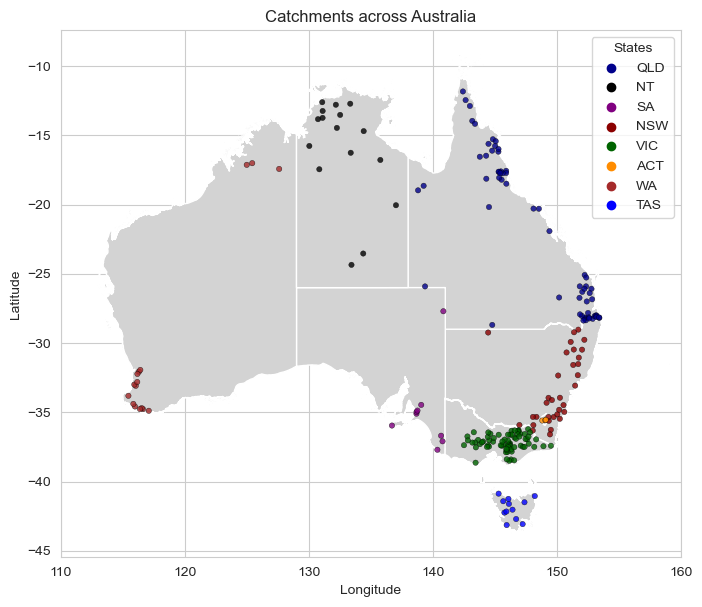

In [39]:
# Load the shapefile of Australia
australia = gpd.read_file('STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp')

# Define the CRS of the shapefile manually
australia.crs = 'epsg:7844'

# Create a GeoDataFrame from the DataFrame of cities
gdf_cities = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longs, df.lats))

# Set the CRS of the GeoDataFrame to EPSG 7844
# https://epsg.io/7844
gdf_cities.crs = 'epsg:7844'

# Reproject the GeoDataFrame of cities to match the CRS of the shapefile
gdf_cities = gdf_cities.to_crs(australia.crs)

# Perform a spatial join to link the cities to their corresponding polygons in the shapefile
gdf_cities = gpd.sjoin(gdf_cities, australia, predicate='within')

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))

# # Define a custom dark color palette
custom_palette = sns.color_palette(['darkblue', 'black', 'purple','darkred', 'darkgreen', 'darkorange', 'brown' , 'blue'], n_colors=len(df['state_num'].unique()))

# Plot the cities colored by priority with adjustments
sns.scatterplot(ax=ax, data=gdf_cities, x='longs', y='lats', hue='States', s=15, palette=custom_palette, edgecolor='black', alpha=0.8, legend='full', zorder=2)


# Set x-axis limits
ax.set_xlim(110, 160)

# Add the shapefile of Australia as a background map
australia.plot(ax=ax, color='lightgrey', edgecolor='white', zorder=1)

# Set the plot title and axis labels
plt.title('Catchments across Australia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

### Conditional Ensemble

In [17]:
camels_data.summary_data['state_outlet'].value_counts()

VIC    72
QLD    61
NSW    33
NT     16
WA     16
TAS    12
SA      9
ACT     3
Name: state_outlet, dtype: int64

In [18]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'WA'].index)

In [19]:
#, 'upper_soil', 'deep_soil'
combined=[]
for i in range(0,1):
    print('RUN',i)
    results_switch=[]
    variable_ts = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
    variable_ts_switch = ['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

    variable_static = ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']

    train_df, test_df = camels_data.get_train_val_test(source=variable_ts, stations=selected_stations)

    multi_window = MultiWindow(input_width=5,
                               label_width=5,
                               shift=5,
                               train_df=train_df,
                               test_df=test_df,
                               stations=selected_stations,
                               label_columns=['streamflow_MLd_inclInfilled'])

    np_window = MultiNumpyWindow(input_width=5, 
                                 label_width=5,
                                 shift=5,
                                 timeseries_source=variable_ts_switch,
                                 summary_source=variable_static,
                                 summary_data=camels_data.summary_data,
                                 stations=selected_stations,
                                 label_columns=['flood_probabilities'])

    model_switch = Switch_Model(window_switch=np_window, window_regular=multi_window, CONV_WIDTH=5) 

    for station in selected_stations:
                results_switch.append(model_switch.summary(station))
    
    Switch_NSW= pd.DataFrame(results_switch)
    Switch_NSW= Switch_NSW.mean()
    Switch_NSW= Switch_NSW.to_dict()
    combined.append(Switch_NSW)


RUN 0


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklea

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LST  (None, 5, 20)                2160      ['TIMESERIES_INPUT[0][0]']    
 M)                                                                                               
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 20)                0         ['BIDIRECTIONAL_LAYER_1[0][0]'
                                                                    ]                         

38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 30ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 33ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 34ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [=================

38/38 [==============================] - 2s 22ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 21ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 21ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 22ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 22ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 22ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 20ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 19ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [=================

38/38 [==============================] - 2s 14ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 13ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 13ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 14ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 11ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 11ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 11ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 12ms/step
Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [=================

In [23]:
Switch3_QLD_bdlstm = pd.DataFrame(combined)
Switch3_QLD_bdlstm= Switch3_QLD_bdlstm.to_csv('WOV_Switch1_WA_lstm_3.csv')

In [21]:
df_date= np_window.test_df['604053'].reset_index()
date_values= df_date['date'][5:-4]

Timeseries input shape: (1187, 5, 6)
Static input shape: (1187, 23)
38/38 [==============================] - 2s 38ms/step


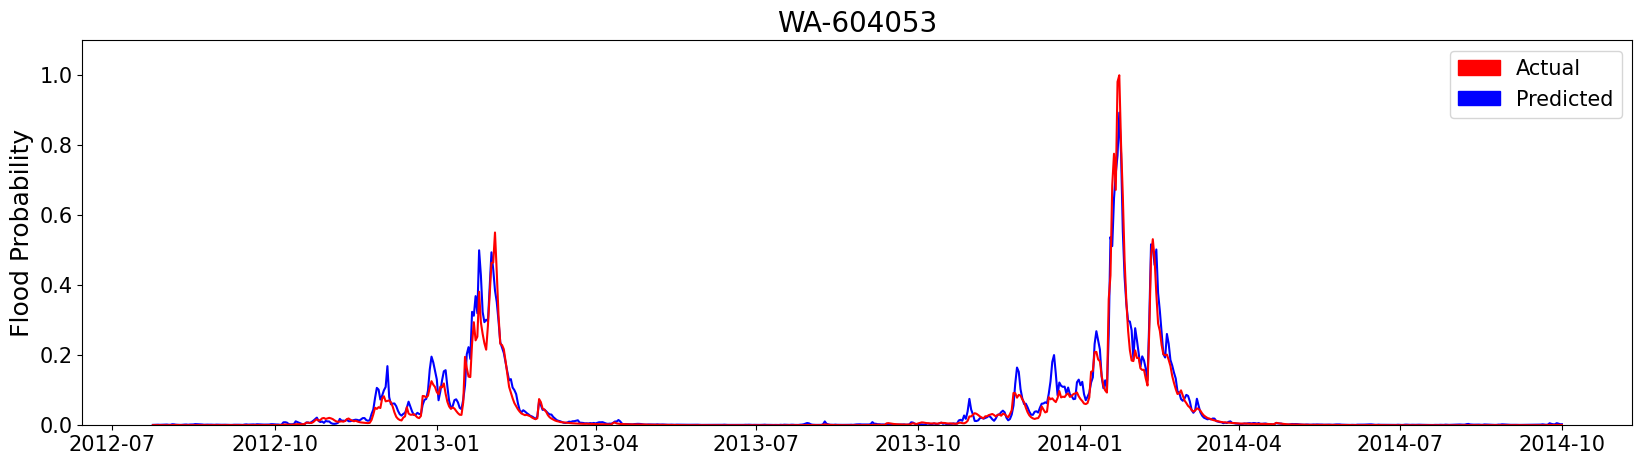

In [28]:
# for dates

import matplotlib.patches as mpatches
fig = plt.figure(figsize=(20,5))
plt.title('WA-604053', fontsize= 20)
# plt.xlabel('')
plt.ylabel('Flood Probability', fontsize=18)
plt.ylim(0, 1.1)

plt.rcParams.update({'font.size': 15})
# plt.set_xlabel(fontsize=15)
# plt.set_ylabel('Flood Probability', fontsize=15)

s=300
e=1100

ax1 = plt.plot(date_values[s:e], model_switch.predictions('604053')[:,0][s:e], color='blue')
ax2 = plt.plot(date_values[s:e], multi_window.test_windows('604053')[:,0][s:e], color='red')

red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Predicted')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

### Individual - SA - All Models

In [21]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)

In [22]:
#['multi-LSTM', 'multi-linear','multi-CNN', 'multi-Bidirectional-LSTM']

combined= []
for i in range(0,10):
    print('RUN', i)
    input_widths = [5]
    label_widths = [5]
    models = ['multi-LSTM']
    variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

    permutations_base = list(itertools.product(*[input_widths, label_widths, selected_stations, models, variables]))

    results_baseModels_variables = []
    models_baseModels_variables = []
    errors_baseModels_variables = []

    for input_width, label_width, station, model_name, variable in permutations_base:
        if input_width < label_width:
            continue

        train_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)

        try:
            print('input_width:{}, label_width:{}, station:{}, model:{}, variables:{}'.format(input_width, label_width, station, model_name, variable))
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(current_time)

            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=label_width,
                                     train_df=train_df,
                                     test_df=test_df,
                                     station=station,
                                     label_columns=['streamflow_MLd_inclInfilled'])

            model = Base_Model(model_name=model_name, window=window, CONV_WIDTH=label_width)

            results_baseModels_variables.append(model.summary())

            pd.DataFrame(results_baseModels_variables).to_csv('results_files/results_ensemble_all_1.csv')

        except:
            errors_baseModels_variables.append([input_width, label_width, station, model])

    Individual_SA= pd.DataFrame(results_baseModels_variables)
    Individual_SA= Individual_SA.mean()
    Individual_SA= Individual_SA.to_dict()
    combined.append(Individual_SA)

RUN 0


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:48:11
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:49:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:51:51
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:53:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:55:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:57:33
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
18:59:22
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:01:17
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:03:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:05:22
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:07:19
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:09:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:11:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:14:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:16:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:18:50
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:21:13
103/103 [==============================] - 1s 4ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:23:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:26:38
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:29:11
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:31:31
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:34:02
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:36:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:38:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:40:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:42:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:44:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:46:07
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:48:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:49:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:51:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:53:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:55:38
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 1
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:57:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:59:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:01:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:03:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:04:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:06:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:08:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:11:06
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:13:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:15:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:17:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:19:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:21:27
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:23:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:24:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:26:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:28:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:30:14
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:31:58
103/103 [==============================] - 0s 1ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:33:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:35:27
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:37:11
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:38:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:40:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:42:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:44:28
103/103 [==============================] - 1s 6ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:46:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:48:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:51:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:53:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:55:15
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:57:28
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:59:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 2
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:01:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:04:16
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:06:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:07:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:09:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:11:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:13:17
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:15:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:16:49
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:18:34
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:20:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:22:05
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:23:49
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:25:34
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:27:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:29:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:30:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:32:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:34:16
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:36:00
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:37:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:39:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:41:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:42:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:44:39
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:46:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:48:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:49:52
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:51:36
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:53:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:55:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:56:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:58:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 3
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:00:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:02:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:03:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:05:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:07:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:09:33
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:11:14
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:13:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:14:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:16:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:18:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:20:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:21:55
103/103 [==============================] - 0s 1ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:23:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:25:27
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:27:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:28:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:30:44
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:32:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:34:15
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:36:00
103/103 [==============================] - 0s 1ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:37:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:39:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:41:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:42:57
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:44:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:46:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:48:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:49:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:51:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:53:24
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:55:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:56:53
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 4
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
22:58:38
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:00:22
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:02:07
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:03:51
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:05:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:07:19
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:09:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:10:49
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:12:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:14:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:16:19
103/103 [==============================] - 0s 1ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:18:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:19:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:22:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:24:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:26:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:28:14
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:30:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:32:34
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:34:45
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:36:54
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:39:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:41:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:43:21
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:45:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:47:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:49:51
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:52:00
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:54:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:56:17
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
23:58:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:00:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:02:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 5
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:04:51
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:07:00
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:09:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:11:16
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:13:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:15:57
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:18:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:20:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:22:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:24:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:27:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:29:24
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:31:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:33:39
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:35:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:38:00
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:40:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:42:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:44:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:46:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:49:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:51:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:53:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:55:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
00:57:59
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:00:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:02:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:04:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:06:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:08:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:11:08
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:13:19
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:15:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 6
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:17:25
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:19:36
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:21:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:23:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:26:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:28:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:30:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:33:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:35:08
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:37:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:39:44
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:42:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:44:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:46:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:48:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:51:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:53:25
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:55:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
01:57:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:00:14
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:02:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:04:44
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:06:59
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:09:14
103/103 [==============================] - 0s 3ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:11:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:13:33
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:15:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:17:15
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:19:05
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:20:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:22:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:24:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:26:27
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 7
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:28:17
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:30:07
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:31:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:33:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:35:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:37:24
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:39:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:41:11
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:43:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:44:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:46:51
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:48:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:50:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:52:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:54:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:56:15
103/103 [==============================] - 0s 1ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
02:58:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:00:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:01:53
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:03:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:05:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:07:28
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:09:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:11:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:13:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:14:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:16:46
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:18:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:20:29
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:22:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:24:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:26:01
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:27:52
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 8
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:29:42
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:31:33
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:33:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:35:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:37:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:39:07
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:41:00
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:42:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:44:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:46:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:48:35
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:50:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:52:23
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:54:16
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:56:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:58:02
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
03:59:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:01:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:03:41
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:05:33
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:07:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:09:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:11:10
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:13:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:14:56
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:16:47
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:18:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:20:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:22:59
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:25:21
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:27:13
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:29:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:31:12
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will 

RUN 9
input_width:5, label_width:5, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:33:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:34:55
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:401015, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:36:49
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410057, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:38:40
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410061, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:40:31
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410705, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:42:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:410734, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:44:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412028, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:46:22
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412050, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:48:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:412066, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:50:14
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416003, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:52:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:416008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:54:03
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:55:58
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:418014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:57:54
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:419005, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
04:59:48
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:424002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:01:43
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:204034, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:03:37
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206014, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:05:31
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:206018, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:07:26
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208007, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:09:20
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:208009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:11:15
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210006, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:13:09
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:210011, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:15:04
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:211008, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:16:57
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212209, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:18:52
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:212260, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:20:45
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:22:38
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:24:32
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:215207, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:26:25
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216002, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:28:18
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:216004, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:30:30
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:218001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:32:24
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, station:219001, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
05:34:17
103/103 [==============================] - 0s 2ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_120072\3034299951.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Individual_SA= Individual_SA.mean()


In [23]:
Individual_SA_bdlstm = pd.DataFrame(combined)
Individual_SA_bdlstm= Individual_SA_bdlstm.to_csv('WOV_Individual_NSW_lstm_1.csv')

### Batch-Indicator LSTM- SA Only

In [20]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'SA'].index)

In [21]:
len(selected_stations)

9

In [24]:
combined= []
for i in range(0,30):
    print('RUN',i)
    input_widths = [5]
    label_widths = [5]
    models = ['multi-LSTM']
    variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

    permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

    results_baseModels_batch = []
    errors_baseModels_batch = []

    for input_width, label_width, model_name, variable in permutations_base_batch:
        try:
            if input_width < label_width:
                continue

            train_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
            multi_window = MultiWindow(input_width=input_width,
                                       label_width=label_width,
                                       shift=label_width,
                                       train_df=train_df,
                                       test_df=test_df,
                                       stations=selected_stations,
                                       label_columns=['streamflow_MLd_inclInfilled'])

            model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

            print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(current_time)

            for station in selected_stations:
                results_baseModels_batch.append(model.summary(station=station))

            pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_all_1.csv')
        except:
            errors_baseModels_batch.append([input_width, label_width, model_name]) 
    Batch_NSW= pd.DataFrame(results_baseModels_batch)
    Batch_NSW= Batch_NSW.mean()
    Batch_NSW= Batch_NSW.to_dict()
    combined.append(Batch_NSW)
    

RUN 0


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:07:34
36/36 [==============================] - 2s 7ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 1
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:16:20
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 2
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:25:37
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 3
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:34:45
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 4
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:44:20
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 5
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
11:54:28
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 6
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:04:07
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 7
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:14:14
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 8
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:23:10
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 9
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:32:24
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 10
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:42:10
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 11
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
12:52:01
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 12
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:00:52
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 13
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:10:17
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 14
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:19:43
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 15
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:29:28
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 16
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:38:07
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 17
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:48:34
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 18
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
13:58:46
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 19
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:08:38
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 20
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:18:27
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 21
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:28:52
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 22
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:38:57
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 23
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:47:45
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 24
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
14:56:45
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 25
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
15:05:21
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 26
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
15:14:48
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 27
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
15:23:30
36/36 [==============================] - 1s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 28
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
15:32:13
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 29
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
15:40:56
36/36 [==============================] - 1s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\2387506938.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()


In [25]:
Batch_NSW_LSTM = pd.DataFrame(combined)
Batch_NSW_LSTM.to_csv('WOV_Batch_SA_LSTM.csv')

### Batch-Static SA- LSTM

In [26]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'SA'].index)

In [27]:
len(selected_stations)

9

In [29]:
combined=[]
for i in range(0,30):
    print('RUN', i)
    input_widths = [5]
    label_widths = [5]
    models = ['multi-LSTM']
    variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']]

    permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

    results_baseModels_batch = []
    errors_baseModels_batch = []

    for input_width, label_width, model_name, variable in permutations_base_batch:
        try:
            if input_width < label_width:
                continue

            train_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
            multi_window = MultiWindow(input_width=input_width,
                                       label_width=label_width,
                                       shift=label_width,
                                       train_df=train_df,
                                       test_df=test_df,
                                       stations=selected_stations,
                                       label_columns=['streamflow_MLd_inclInfilled'])

            model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

            print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(current_time)

            for station in selected_stations:
                results_baseModels_batch.append(model.summary(station=station))

            pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_static_all_1.csv')
        except:
            errors_baseModels_batch.append([input_width, label_width, model])
    Batch_NSW= pd.DataFrame(results_baseModels_batch)
    Batch_NSW= Batch_NSW.mean()
    Batch_NSW= Batch_NSW.to_dict()
    combined.append(Batch_NSW)

RUN 0


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
16:49:20
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 1
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
17:07:52
67/67 [==============================] - 2s 5ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 2
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
17:27:11
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 3
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
17:46:36
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 4
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
18:03:55
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 5
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
18:19:25
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 6
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
18:35:06
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 7
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
18:51:04
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 8
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
19:06:56
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 9
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
19:22:52
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 10
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
19:38:42
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 11
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
19:54:35
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 12
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
20:10:28
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 13
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
20:26:19
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 14
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
20:42:15
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 15
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
20:58:08
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 16
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
21:14:03
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 17
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
21:29:58
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 18
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
21:45:54
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 19
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
22:01:49
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 20
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
22:17:53
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 21
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
22:35:25
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 22
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
22:53:53
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 23
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
23:12:59
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 24
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
23:30:24
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 25
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
23:47:56
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 26
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
00:04:50
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 27
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
00:22:09
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 28
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
00:39:59
67/67 [==============================] - 2s 4ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised

RUN 29
input_width:5, label_width:5, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']
09:57:30
67/67 [==============================] - 2s 3ms/step


C:\Users\siddh\AppData\Local\Temp\ipykernel_17404\1138937705.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Batch_NSW= Batch_NSW.mean()


In [30]:
Batch_NSW_LSTM = pd.DataFrame(combined)
Batch_NSW_LSTM.to_csv('WOV_BatchStatic_SA_LSTM.csv')

### Ensemble Model

In [23]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'SA'].index)

In [24]:
len(selected_stations)

9

In [27]:
combined=[]
for i in range(0,15):
    print('RUN:', i)
    results_ensemble = []
    input_widths = [5]
    label_widths = [5]

    permutations_ensemble = list(itertools.product(*[input_widths, label_widths]))

    for input_width, label_width in permutations_ensemble:
        np_window = MultiNumpyWindow(input_width=input_width, 
                                     label_width=label_width,
                                     shift=label_width,
                                     timeseries_source=['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'],
                                     summary_source=['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq'],
                                     summary_data=camels_data.summary_data,
                                     stations=selected_stations,
                                     label_columns=['streamflow_MLd_inclInfilled'])

        ensemble_model = Ensemble_Static(np_window)
        ensemble_model.train()
        print('done')

        for station in selected_stations:
            results_ensemble.append(ensemble_model.summary(station))
                
    Ensemble_NSW= pd.DataFrame(results_ensemble)
    Ensemble_NSW= Ensemble_NSW.mean()
    Ensemble_NSW= Ensemble_NSW.to_dict()
    combined.append(Ensemble_NSW)

RUN: 0


C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_30 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_30[0][0]']    
                                                                                           

904/904 [==============================] - 7s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 47/100
904/904 [==============================] - 7s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 48/100
904/904 [==============================] - 8s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 49/100
904/904 [==============================] - 8s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 50/100
904/904 [==============================] - 6s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 51/100
904/904 [==============================] - 6s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 52/100
904/904 [==============================] - 6s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0235
Epoch 53/100
904/904 [==============================] - 7s 8ms/step - loss: 0.0039 - mean_absolute_error: 0.0234
Epoch 54/100
904/904 [==============================] - 8s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
186.24000819717685
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
191.76204853941226
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
195.0696276285721
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.8184767694015
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.15209367871284
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.16344887018204
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
6

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_32 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_32[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
187.82786006482002
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
193.19577061788095
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
195.99467116262622
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.2127050939025
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.3454966545105
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.56061623618007
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
6

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_34 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_34[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
184.8635486338826
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
190.51439880834732
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
194.07421136820994
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.04164825966654
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
77.54279044270515
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
101.31135093048215
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_36 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_36[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
184.27856855177652
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
189.91923378416686
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
193.33908924719435
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
197.15565405788948
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
77.79059161245823
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
101.7710734680295
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_38 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_38[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
192.20251728129642
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
197.33075370808342
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.19726977527876
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
201.41560401093716
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
79.1578338444233
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
103.84321070834994
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_40 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_40[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
185.7261415268963
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
191.17003517762123
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
194.12261194745724
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
197.47496629586158
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
77.7840498611331
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
101.73877945169806
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
6

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_42 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_42[0][0]']    
                                                                                           

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
187.0053595314921
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
192.35661508697103
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
195.07304758987175
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.17261739309197
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.45533225685358
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.75039893761277
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_44 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_44[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
185.766438005704
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
191.37730492434366
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
194.6876830388328
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.38254548651184
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
77.50293885916471
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
101.23305398970842
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_46 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_46[0][0]']    
                                                                                           

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
188.20704292274877
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
193.52707057041243
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
196.18172236695955
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.22470344796147
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.23239427059889
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.43636973202229
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_48 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_48[0][0]']    
                                                                                           

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
185.81579395187805
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
191.46909941647687
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
194.98711937435223
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.91023027736014
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.15759610384703
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
102.18988677859306
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_50 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_50[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
186.27233289063815
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
191.8985956459078
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
195.32651873480108
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.16120732633908
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
77.69425133615732
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
101.61804803833365
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


TSET Y SHAPE (19260, 1, 5)
271.56262543026014
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
274.1675331377751
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
278.1495439586556
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
93.81181433051825
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.88326362121734
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
116.54318334150594
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
T

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_52 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_52[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
188.99295049012835
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
194.29475881492635
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
196.83179582060347
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.74932270181398
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.90512479841709
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
103.43816187605262
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_54 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_54[0][0]']    
                                                                                           

67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
188.08257825916735
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
193.48659516762746
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
196.3485714370563
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
199.5923434887609
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.50213601440191
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.75605819746852
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
6

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_56 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_56[0][0]']    
                                                                                           

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
190.13818552180783
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
195.32462640563517
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
197.54372620323466
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
200.13576449948505
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
78.75237745791674
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
103.21308728680015
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)

C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\siddh\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TIMESERIES_INPUT (InputLay  [(None, 5, 6)]               0         []                            
 er)                                                                                              
                                                                                                  
 bidirectional_58 (Bidirect  (None, 5, 40)                4320      ['TIMESERIES_INPUT[0][0]']    
 ional)                                                                                           
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)   (None, 5, 40)                0         ['bidirectional_58[0][0]']    
                                                                                           

67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
188.19872707571085
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
193.49480860670064
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 3ms/step
TSET Y SHAPE (19260, 1, 5)
196.0505391628967
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
198.99378481660005
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
78.35752619057894
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)
67/67 [==============================] - 0s 2ms/step
TSET Y SHAPE (19260, 1, 5)
102.59599668160081
Timeseries input shape: (2140, 5, 6)
Static input shape: (2140, 16)


C:\Users\siddh\AppData\Local\Temp\ipykernel_136952\1713836014.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ensemble_NSW= Ensemble_NSW.mean()


In [28]:
Ensemble_NSW_LSTM = pd.DataFrame(combined)
Ensemble_NSW_LSTM.to_csv('WOV_Ensemble_SA_LSTM_2.csv')

### Batch Model

In [ ]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'VIC'].index)

In [ ]:
selected_stations

In [ ]:
len(selected_stations)

In [ ]:
input_widths = [5]
label_widths = [5]
models = ['multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

results_baseModels_batch = []
errors_baseModels_batch = []

for input_width, label_width, model_name, variable in permutations_base_batch:
    try:
        if input_width < label_width:
            continue

        train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
        multi_window = MultiWindow(input_width=input_width,
                                   label_width=label_width,
                                   shift=label_width,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   stations=selected_stations,
                                   label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

        print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)

        for station in selected_stations:
            results_baseModels_batch.append(model.summary(station=station))
         
        pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_all_1.csv')
    except:
        errors_baseModels_batch.append([input_width, label_width, model_name]) 

In [ ]:
len(results_baseModels_batch)

In [ ]:
Batch_VIC_bilstm= pd.DataFrame(results_baseModels_batch)
Batch_VIC_bilstm.to_csv('Batch_VIC_bilstm.csv')

### Individual

In [ ]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'SA'].index)

In [ ]:
selected_stations

In [ ]:
len(selected_stations)

In [ ]:
input_widths = [5]
label_widths = [5]
models = ['multi-LSTM', 'multi-linear','multi-CNN', 'multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

permutations_base = list(itertools.product(*[input_widths, label_widths, selected_stations, models, variables]))
 
results_baseModels_variables = []
models_baseModels_variables = []
errors_baseModels_variables = []

for input_width, label_width, station, model_name, variable in permutations_base:
    if input_width < label_width:
        continue
        
    train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
     
    try:
        print('input_width:{}, label_width:{}, station:{}, model:{}, variables:{}'.format(input_width, label_width, station, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)
        
        window = WindowGenerator(input_width=input_width,
                                 label_width=label_width,
                                 shift=label_width,
                                 train_df=train_df,
                                 val_df=val_df,
                                 test_df=test_df,
                                 station=station,
                                 label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=window, CONV_WIDTH=label_width)
        
        results_baseModels_variables.append(model.summary())
          
        pd.DataFrame(results_baseModels_variables).to_csv('results_files/results_ensemble_all_1.csv')
        
    except:
        errors_baseModels_variables.append([input_width, label_width, station, model])

In [ ]:
len(results_baseModels_variables)

In [ ]:
Individual_SA= pd.DataFrame(results_baseModels_variables)
Individual_SA.to_csv('Individual_SA.csv')

### Batch Static

In [ ]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'ACT'].index)

In [ ]:
len(selected_stations)

In [ ]:
selected_stations

In [ ]:
input_widths = [5]
label_widths = [5]
models = ['multi-LSTM', 'multi-linear','multi-CNN', 'multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']]

permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

results_baseModels_batch = []
errors_baseModels_batch = []

for input_width, label_width, model_name, variable in permutations_base_batch:
    try:
        if input_width < label_width:
            continue

        train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
        multi_window = MultiWindow(input_width=input_width,
                                   label_width=label_width,
                                   shift=label_width,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   stations=selected_stations,
                                   label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

        print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)

        for station in selected_stations:
            results_baseModels_batch.append(model.summary(station=station))
         
        pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_static_all_1.csv')
    except:
        errors_baseModels_batch.append([input_width, label_width, model])

In [ ]:
Batchstatic_ACT= pd.DataFrame(results_baseModels_batch)
Batchstatic_ACT.to_csv('Batchstatic_ACT.csv')